In [1]:
import sys
sys.path.append("..")

import torch
import torch.nn.functional as F

/home/yourenz/.conda/envs/proto/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [2]:
import timm, tome

# Load a pretrained model, can be any vit / deit model.
# model = timm.create_model("vit_large_patch16_224", pretrained=True)
model = timm.create_model("vit_base_patch16_224", pretrained=True)
# Patch the model with ToMe.
# tome.patch.timm(model)
# Set the number of tokens reduced per layer. See paper for details.
# model.r = 16

/home/yourenz/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yourenz/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=T

In [4]:
blk = model.blocks[0]
blk

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate=none)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)

In [5]:
blk.norm1

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [6]:
imgs = torch.randn(4, 3, 224, 224)
model(imgs).shape

torch.Size([4, 1000])

In [7]:
embed = model.patch_embed(imgs)
embed.shape

torch.Size([4, 196, 768])

In [8]:
attn_scores = blk.attn(embed)

In [9]:
blk.norm2(attn_scores).shape

torch.Size([4, 196, 768])

In [10]:
attn_scores[0][1].sum()

tensor(1.5827, grad_fn=<SumBackward0>)

In [11]:
test = torch.randn(4, 196, 748)
test.shape

torch.Size([4, 196, 748])

# KNN density

In [9]:
embed.unsqueeze(2).shape

torch.Size([4, 196, 1, 768])

In [10]:
dist_mat = (embed.unsqueeze(2) - embed.unsqueeze(1) ** 2).sum(-1)

In [11]:
K = 10
d_knn, ind_knn = dist_mat.topk(K, largest=False)

In [12]:
d_knn.shape

torch.Size([4, 196, 10])

In [13]:
neighbors_dist = d_knn.mean(dim=-1)
score_first_order = K / neighbors_dist

In [14]:
score_first_order.shape

torch.Size([4, 196])

# Data

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image

/home/yourenz/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yourenz/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from classes import IMAGENET2012_CLASSES

In [4]:
CODE2LABEL = {k: idx for idx, k in enumerate(IMAGENET2012_CLASSES.keys())}
LABEL2CODE = {idx: k for idx, k in enumerate(IMAGENET2012_CLASSES.keys())}

In [5]:
CODE2LABEL["ILSVRC2012_val_00033297_n03180011".split("_")[-1]]

527

In [6]:
class SubImageNet(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        root = Path(root)
        
        self.img_paths, self.targets = [], []
        for img in root.iterdir():
            self.img_paths.append(str(img))
            self.targets.append(CODE2LABEL[img.stem.split("_")[-1]])
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.targets[idx]
        
        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')
        
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

val_trfm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

root = "/nfs/turbo/coe-stellayu/youren/datasets/imagenet_1k/val"

val_ds = SubImageNet(root, transform=val_trfm)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)

# Feed to Model

In [18]:
def predict(model, imgs):
    logits = model(imgs)
    pred = logits.argmax(axis=-1)
    return pred

def acc(pred, labels):
    return (pred == labels).sum() / labels.size(0)

In [19]:
imgs, labels = next(iter(val_dl))

In [20]:
model.cuda()
model.eval()
imgs, labels = imgs.cuda(), labels.cuda()

In [21]:
pred = predict(model, imgs)

In [22]:
pred == labels

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True, False,  True,
         True,  True], device='cuda:0')

In [23]:
labels

tensor([343, 323, 339, 813, 932, 518, 979, 959, 147,  64, 454, 359, 134, 651,
        695, 585, 244, 693, 168, 140, 154, 192, 913, 163, 962, 703,  72, 987,
        886, 288, 634, 956], device='cuda:0')

In [24]:
acc(pred, labels)

tensor(0.8438, device='cuda:0')

## hook

In [25]:
model.blocks[0].attn

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [26]:
from collections import defaultdict


activation = {}
qkv_dict = {}
def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output[:, 1:, :].cpu().detach()
    return hook

def get_qkv(name, activation):
    def hook(model, input, output):
        B, N, C = input[0].shape
        activation[name] = output.cpu().detach().reshape(B, N, 3, 12, C // 12).permute(2, 0, 3, 1, 4)[:, :, :, 1:, :]
    return hook

for idx, blk in enumerate(model.blocks):
    blk.register_forward_hook(get_activation(f'tokens_{idx}', activation))
    blk.attn.qkv.register_forward_hook(get_qkv(f'layer_{idx}', qkv_dict))

pred = predict(model, imgs)

In [27]:
activation["tokens_0"].shape

torch.Size([32, 196, 768])

In [28]:
qkv_dict["layer_0"].shape

torch.Size([3, 32, 12, 196, 64])

# ToMe Model

In [33]:
import tome
from tome.utils import parse_r

# Load a pretrained model, can be any vit / deit model.
tome_model = timm.create_model("vit_base_patch16_224", pretrained=True)
# Patch the model with ToMe.
tome.patch.timm(tome_model)
# Set the number of tokens reduced per layer. See paper for details.
tome_model.r = 13

In [34]:
tome_model._tome_info

{'r': 0,
 'size': None,
 'source': None,
 'trace_source': False,
 'prop_attn': True,
 'class_token': True,
 'distill_token': False}

In [35]:
# imgs = torch.randn(4, 3, 224, 224)
tome_model.cuda()
tome_model.eval()
tome_model(imgs).shape

torch.Size([32, 1000])

In [36]:
tome_model._tome_info["r"] = parse_r(len(tome_model.blocks), tome_model.r)
tome_model._tome_info["size"] = None
tome_model._tome_info["source"] = None
print(tome_model._tome_info)

embed = tome_model.patch_embed(imgs)
print(embed.shape)

tome_model.blocks(embed).shape

{'r': [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13], 'size': None, 'source': None, 'trace_source': False, 'prop_attn': True, 'class_token': True, 'distill_token': False}
torch.Size([32, 196, 768])


torch.Size([32, 196, 768])

In [38]:
tome_model._tome_info["size"]

# Proto and Visualize

In [29]:
import matplotlib.pyplot as plt

In [30]:
imgs.shape

torch.Size([32, 3, 224, 224])

In [31]:
all_samples = torch.cat([tokens.unsqueeze(1) for tokens in activation.values()], axis=1)
all_samples = all_samples

In [32]:
all_samples.shape

torch.Size([32, 12, 196, 768])

In [33]:
all_samples_mean = all_samples.mean(axis=1)
all_samples_mean.shape

torch.Size([32, 196, 768])

In [98]:
K = 100
num_patch = 14

# dist_mat = ((all_samples_mean.unsqueeze(2) - all_samples_mean.unsqueeze(1)) ** 2).sum(-1)

feat = F.normalize(all_samples_mean, dim=-1)
dist_mat = (2 - 2 * torch.matmul(feat, feat.permute(0, 2, 1)))

d_knn, ind_knn = dist_mat.topk(K, largest=False)
neighbors_dist = d_knn.mean(dim=-1)
score_first_order = K / neighbors_dist

In [99]:
dist_mat.shape

torch.Size([32, 196, 196])

In [85]:
dist_mat.topk(K, largest=False).values.shape

torch.Size([32, 196, 100])

In [86]:
score_first_order.shape

torch.Size([32, 196])

In [87]:
_, indices = score_first_order.topk(k=13, axis=1, largest=False)

In [88]:
indices.shape

torch.Size([32, 13])

In [89]:
indices = indices.unsqueeze(2).expand(-1, -1, 768)
indices.shape

torch.Size([32, 13, 768])

In [90]:
indices[0, 1, 3]

tensor(103)

In [91]:
all_samples_mean.shape

torch.Size([32, 196, 768])

In [92]:
selected = torch.gather(all_samples_mean, dim=1, index=indices)

In [93]:
selected.shape

torch.Size([32, 13, 768])

In [36]:
def plot_res(mode, K, num_patch = 14):
    if mode == "token":
        all_samples = torch.cat([tokens.unsqueeze(1) for tokens in activation.values()], axis=1)
    elif mode == "q":
        all_samples = torch.cat([qkv[0].mean(1).unsqueeze(1) for qkv in qkv_dict.values()], axis=1)
    elif mode == "k":
        all_samples = torch.cat([qkv[1].mean(1).unsqueeze(1) for qkv in qkv_dict.values()], axis=1)
    elif mode == "v":
        all_samples = torch.cat([qkv[2].mean(1).unsqueeze(1) for qkv in qkv_dict.values()], axis=1)
    else:
        raise ValueError
        
    img = imgs[img_idx].permute(1, 2, 0).cpu().detach()

    samples = all_samples[img_idx]
    
    # feat = F.normalize(samples, dim=-1)
    # dist_mat = (2 - 2 * torch.matmul(feat, feat.permute(0, 2, 1)))

    dist_mat = ((samples.unsqueeze(2) - samples.unsqueeze(1)) ** 2).sum(-1)
    d_knn, ind_knn = dist_mat.topk(K, largest=False)

    neighbors_dist = d_knn.mean(dim=-1)
    score_first_order = K / neighbors_dist
    patch_scores = score_first_order.reshape(-1, num_patch, num_patch)

    f, axes = plt.subplots(1, 13, figsize=(30, 10))
    
    axes[0].imshow(img)
    axes[0].axis(False)
    
    for idx, score in enumerate(patch_scores, start=1):
        axes[idx].matshow(score.cpu().detach())
        axes[idx].axis(False)
        # axes[idx].set_title(f"Layer {idx}")  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

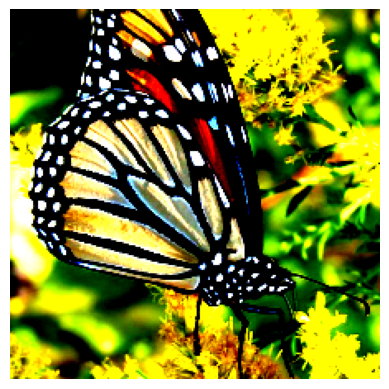

In [59]:
img_idx = 1

img = imgs[img_idx].permute(1, 2, 0).cpu().detach()
plt.imshow(img)
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


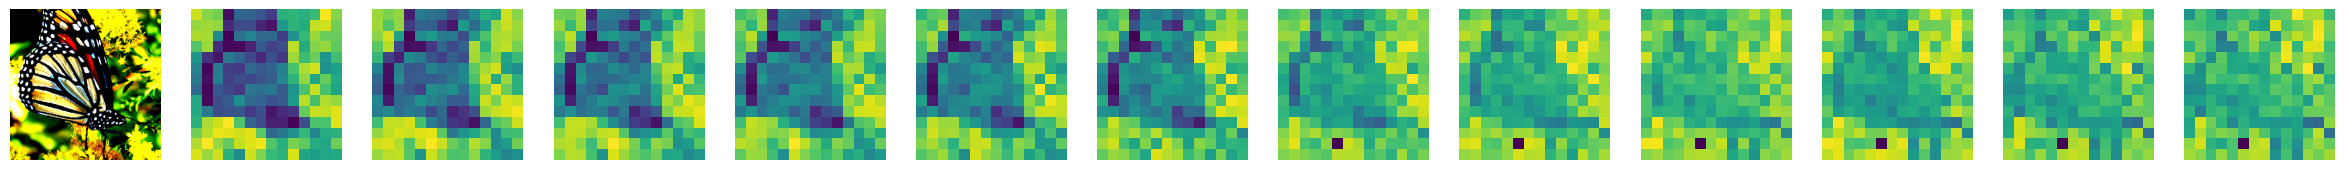

In [60]:
K = 100

plot_res("token", K=K)
# plot_res("q", K=K)
# plot_res("k", K=K)
# plot_res("v", K=K)

# ProtoBlock

In [37]:
def parse_r(num_layers, r):
    inflect = 0
    if isinstance(r, list):
        if len(r) < num_layers:
            r = r + [0] * (num_layers - len(r))
        return list(r)
    elif isinstance(r, tuple):
        r, inflect = r

    min_val = int(r * (1.0 - inflect))
    max_val = 2 * r - min_val
    step = (max_val - min_val) / (num_layers - 1)

    return [int(min_val + step * i) for i in range(num_layers)]

In [42]:
parse_r(12, (13, -1))

[26, 23, 21, 18, 16, 14, 11, 9, 7, 4, 2, 0]

In [ ]:
from timm.models.vision_transformer import Attention, Block, VisionTransformer
# from src.models.vit_backbones.vit import Block


class ProtoBlock(Block):
    
    def _drop_path1(self, x):
        return self.drop_path1(x) if hasattr(self, "drop_path1") else self.drop_path(x)

    def _drop_path2(self, x):
        return self.drop_path2(x) if hasattr(self, "drop_path2") else self.drop_path(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.r, self.K, self.mode = self._proto_info["r"], self._proto_info["K"], self._proto_info["mode"]
        assert self.K is not None and self.mode is not None, f"Please set proto params before forward, got K={self.K}, mode={self.mode}"

        x_attn = self.attn(self.norm1(x))
        x = x + self._drop_path1(x_attn)

        if self.r > 0:
            # Apply prototyping
            cls_token, tokens = x[:, :1, :], x[:, 1:, :]
            
            num_tokens = tokens.size(1)
            knn_k = int(num_tokens * self.K)
            
            # dist_mat = ((tokens.unsqueeze(2) - tokens.unsqueeze(1)) ** 2).sum(-1)
            tokens_norm = F.normalize(tokens, dim=-1)
            dist_mat = (2 - 2 * torch.matmul(tokens_norm, tokens_norm.permute(0, 2, 1)))
            
            d_knn, ind_knn = dist_mat.topk(knn_k, largest=False)

            neighbors_dist = d_knn.mean(dim=-1)
            score_first_order = 1 / neighbors_dist
            
            del dist_mat, d_knn, ind_knn, neighbors_dist, tokens_norm
            
            p = num_tokens - min(self.r, (num_tokens - 1) // 2) # only reduce by a maximum of 50% tokens
            
            if self.mode == "min":
                _, indices = score_first_order.topk(k=p, axis=1, largest=True)
            if self.mode == "max":
                _, indices = score_first_order.topk(k=p, axis=1, largest=False)
            if self.mode == "minmax":
                _, indices_min = score_first_order.topk(k=p // 2, axis=1, largest=True)
                _, indices_max = score_first_order.topk(k=p - p // 2, axis=1, largest=False)
                indices = torch.cat([indices_min, indices_max], axis=1)
            
            del score_first_order
            
            indices = indices.unsqueeze(2).expand(-1, -1, tokens.size(-1))
            selected_tokens = torch.gather(tokens, dim=1, index=indices)
            x = torch.cat([cls_token, selected_tokens], axis=1)
        
        self._proto_info["num_tokens_tracker"].append(x.size(1))
        x = x + self._drop_path2(self.mlp(self.norm2(x)))
        return x
    
embed = embed.cuda()
proto_blk = ProtoBlock(dim=768, num_heads=12)
proto_blk.cuda()
proto_blk._proto_info = {"r": 10, "K": 0.5, "mode": "min", "num_tokens_tracker": []}
proto_blk(embed).shape

torch.Size([4, 186, 768])

# ProtoViT

In [38]:
def make_proto_class(transformer_class):
    class ProtoVisionTransformer(transformer_class):

        def forward(self, *args, **kwdargs) -> torch.Tensor:
            self._proto_info["r"] = self.r
            self._proto_info["num_tokens_tracker"] = []

            return super().forward(*args, **kwdargs)
        
        @property
        def num_tokens(self):
            return self._proto_info["num_tokens_tracker"]

    return ProtoVisionTransformer


def apply_patch(model, K, mode):
    """
    Applies ToMe to this transformer. Afterward, set r using model.r.

    If you want to know the source of each token (e.g., for visualization), set trace_source = true.
    The sources will be available at model._tome_info["source"] afterward.

    For proportional attention, set prop_attn to True. This is only necessary when evaluating models off
    the shelf. For trianing and for evaluating MAE models off the self set this to be False.
    """
    ProtoVisionTransformer = make_proto_class(model.__class__)

    model.__class__ = ProtoVisionTransformer
    model.r = 0
    model._proto_info = {
        "r": model.r,
        "K": K,
        "mode": mode,
        "num_tokens_tracker": []
    }

    for module in model.modules():
        if isinstance(module, Block):
            module.__class__ = ProtoBlock
            module._proto_info = model._proto_info

In [39]:
imgs = imgs.cuda()

In [40]:
proto_model = timm.create_model("vit_base_patch16_224", pretrained=True)
apply_patch(proto_model, K=0.5, mode="min")
proto_model.r = 20

proto_model.cuda()
proto_model.eval()
proto_model(imgs).shape

torch.Size([4, 1000])

In [41]:
proto_model(imgs).shape

torch.Size([4, 1000])

In [34]:
proto_model.num_tokens

[177, 157, 137, 117, 97, 77, 57, 37, 20, 11, 7, 5]

In [36]:
import proto

proto.utils.benchmark(proto_model, device="cuda", batch_size=128)

698.8448047009763

In [83]:
import proto

# Load a pretrained model, can be any vit / deit model.
proto_model = timm.create_model("vit_base_patch16_224", pretrained=True)
# Patch the model with ToMe.
proto.patch.timm(proto_model, K=0.5, mode="min")
# Set the number of tokens reduced per layer. See paper for details.
proto_model.r = 13

In [84]:
proto_model.cuda()
proto_model(imgs).shape

torch.Size([32, 1000])

# Random Drop

In [109]:
from timm.models.vision_transformer import Block, Attention

class RandomDropBlock(Block):
    
    def _drop_path1(self, x):
        return self.drop_path1(x) if hasattr(self, "drop_path1") else self.drop_path(x)

    def _drop_path2(self, x):
        return self.drop_path2(x) if hasattr(self, "drop_path2") else self.drop_path(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.r = self._rd_info["r"]
        
        x_attn, attn_scores = self.attn(self.norm1(x))
        x = x + self._drop_path1(x_attn)

        if self.r > 0:
            cls_token, tokens = x[:, :1, :], x[:, 1:, :]
            num_tokens = tokens.size(1)
            p = num_tokens - min(self.r, (num_tokens - 1) // 2) # only reduce by a maximum of 50% tokens
            # Apply random drop
            if self._rd_info["weighted"]:
                attn_scores = attn_scores.mean(axis=1)
                cls_prob = attn_scores[:, 0, 1:].softmax(dim=-1)
                ps = cls_prob[0].cpu().detach().numpy()
                indices = np.concatenate([
                    np.random.choice(np.arange(num_tokens), p, p=prob[idx].cpu().detach().numpy())[None, :] \
                    for idx, prob in zip(range(tokens.size(0)), cls_prob)])
            else:
                indices = np.concatenate([
                    np.random.choice(np.arange(num_tokens), p)[None, :] for idx in range(tokens.size(0))])
                
            indices = torch.tensor(indices).cuda()
            indices = indices.unsqueeze(2).expand(-1, -1, tokens.size(-1))
            selected_tokens = torch.gather(tokens, dim=1, index=indices)
            x = torch.cat([cls_token, selected_tokens], axis=1)

            del cls_token, tokens
        
        self._rd_info["num_tokens_tracker"].append(x.size(1))
        x = x + self._drop_path2(self.mlp(self.norm2(x)))
        return x
    
class RandomDropAttention(Attention):

    def forward(self, x: torch.Tensor, size: torch.Tensor = None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        attn_scores = attn.detach()
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        # Return k as well here
        return x, attn_scores
    
embed = embed.cuda()
proto_blk = RandomDropBlock(dim=768, num_heads=12)
proto_blk.attn.__class__ =  RandomDropAttention
proto_blk.cuda()
proto_blk._rd_info = {"r": 10, "num_tokens_tracker": [], "weighted": True}
proto_blk(embed).shape

TypeError: len() of unsized object

In [58]:
attn_scores = attn_scores.mean(axis=1)

In [59]:
attn_scores.shape

torch.Size([4, 196, 196])

In [130]:
attn_scores = torch.randn(4, 196, 196) * 100

In [131]:
cls_prob = attn_scores[:, 0, 1:].softmax(dim=-1)

In [132]:
cls_prob.shape

torch.Size([4, 195])

In [142]:
cls_prob[2].cpu().numpy().sum()

0.99999994

In [135]:
cls_prob[1].shape

torch.Size([195])

In [136]:
ps = [None]

In [137]:
from itertools import zip_longest

idxs = np.concatenate([np.random.choice(np.arange(195), 20, p=cls_prob[idx].cpu().detach())[None, :] for idx, p in zip(range(4), cls_prob)])

ValueError: probabilities do not sum to 1

In [93]:
torch.tensor(idxs)

tensor([[130, 102,   0, 118, 148,  48,  50, 163,  69, 192,  31, 118,  68, 136,
         193, 153,  22,  70,  31,  73],
        [138,  98, 156,  16,  74, 100, 105,   8,  32,  39, 135,  81,   9, 129,
         114, 194,  27, 176, 148, 190],
        [ 76,  15,  25, 112,  27,  12, 148,  80,  81,  62,  63,  77,  91,  66,
          79,  75, 166,  74, 140,  66],
        [ 56,  84,  19,  61,  33,  65,  79,  79,  13, 192, 123,  50, 116,  87,
          68,  69, 157,  39, 122, 105]])

In [70]:
import numpy as np

draw = np.random.choice(np.arange(195), 20, p=None)
draw

array([188, 187, 166,  56,  92,  51, 176,   8,  30,   8,  56,   3, 167,
       150, 163,  12,  69,  45,   0,  26])

In [76]:
draw[None, :]

array([[188, 187, 166,  56,  92,  51, 176,   8,  30,   8,  56,   3, 167,
        150, 163,  12,  69,  45,   0,  26]])

In [46]:
def make_rd_class(transformer_class):
    class RandomDropTransformer(transformer_class):

        def forward(self, *args, **kwdargs) -> torch.Tensor:
            self._rd_info["r"] = self.r
            self._rd_info["num_tokens_tracker"] = []

            return super().forward(*args, **kwdargs)
        
        @property
        def num_tokens(self):
            return self._rd_info["num_tokens_tracker"]

    return RandomDropTransformer


def apply_patch(model):
    """
    Applies ToMe to this transformer. Afterward, set r using model.r.

    If you want to know the source of each token (e.g., for visualization), set trace_source = true.
    The sources will be available at model._tome_info["source"] afterward.

    For proportional attention, set prop_attn to True. This is only necessary when evaluating models off
    the shelf. For trianing and for evaluating MAE models off the self set this to be False.
    """
    RandomDropTransformer = make_rd_class(model.__class__)

    model.__class__ = RandomDropTransformer
    model.r = 0
    model._rd_info = {
        "r": model.r,
        "num_tokens_tracker": []
    }

    for module in model.modules():
        if isinstance(module, Block):
            module.__class__ = RandomDropBlock
            module._rd_info = model._rd_info

In [47]:
imgs = imgs.cuda()

In [48]:
rd_model = timm.create_model("vit_base_patch16_224", pretrained=True)
apply_patch(rd_model)
rd_model.r = 13

rd_model.cuda()
rd_model.eval()
rd_model(imgs).shape

torch.Size([4, 1000])

In [49]:
rd_model.num_tokens

[184, 171, 158, 145, 132, 119, 106, 93, 80, 67, 54, 41]

# Comparison

In [8]:
import sys
sys.path.append("..")

import pandas as pd
import torch
import timm

import proto
import tome

In [10]:
from tqdm import tqdm

def evaluate(model, dataloader, device):
    model.eval()
    valid_metrics = MetricTracker("Acc")
    stream = tqdm(dataloader)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(stream):
            data, target = data.to(device), target.to(device)

            output = model(data)
            valid_metrics.update("Acc", accuracy(output, target))
            stream.set_description(f"Validation: {valid_metrics.result()}")
            
    return valid_metrics.result()

def accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = 0
        correct += torch.sum(pred == target).item()
    return correct / len(target)

class MetricTracker:
    def __init__(self, *keys, writer=None):
        self.writer = writer
        self._data = pd.DataFrame(index=keys, columns=['total', 'counts', 'average'])
        self.reset()

    def reset(self):
        for col in self._data.columns:
            self._data[col].values[:] = 0

    def update(self, key, value, n=1):
        if self.writer is not None:
            self.writer.add_scalar(key, value)
        self._data.total[key] += value * n
        self._data.counts[key] += n
        self._data.average[key] = self._data.total[key] / self._data.counts[key]

    def avg(self, key):
        return self._data.average[key]

    def result(self):
        return dict(self._data.average)

In [11]:
from tqdm import tqdm

def evaluate(model, dataloader, device):
    model.eval()
    valid_metrics = MetricTracker("Acc")
    stream = tqdm(dataloader)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(stream):
            data, target = data.to(device), target.to(device)

            output = model(data)
            valid_metrics.update("Acc", accuracy(output, target))
            stream.set_description(f"Validation: {valid_metrics.result()}")
            
    return valid_metrics.result()

In [14]:
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=8)

### Original

In [23]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.cuda()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=T

In [34]:
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
evaluate(model, sub_imagenet_val_dl, "cuda")

Validation: {'Acc': 0.780090371081254}: 100%|██████████| 1563/1563 [03:05<00:00,  8.41it/s] 


{'Acc': 0.780090371081254}

In [24]:
proto.utils.benchmark(model, device="cuda", batch_size=32)

304.4778833521294

### ToMe

In [42]:
tome_model = timm.create_model("vit_base_patch16_224", pretrained=True)
tome_model.cuda()
tome.patch.timm(tome_model)
tome_model.r = 19

In [43]:
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=8)
evaluate(tome_model, sub_imagenet_val_dl, "cuda")

Validation: {'Acc': 0.6467511189258311}: 100%|██████████| 391/391 [01:28<00:00,  4.44it/s]


{'Acc': 0.6467511189258311}

In [44]:
proto.utils.benchmark(tome_model, device="cuda", batch_size=128)

685.3318927265356

### RandomDrop

In [32]:
rd_model = timm.create_model("vit_base_patch16_224", pretrained=True)
rd_model.cuda()
proto.patch.rand_drop(rd_model)
rd_model.r = 13

In [33]:
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
evaluate(rd_model, sub_imagenet_val_dl, "cuda")

Validation: {'Acc': 0.7776442307692307}:   5%|▍         | 78/1563 [00:10<03:12,  7.71it/s]


KeyboardInterrupt: 

In [ ]:
proto.utils.benchmark(rd_model, device="cuda", batch_size=128)

### Proto

In [12]:
def parse_r(num_layers, r):
    """
    Process a constant r or r schedule into a list for use internally.

    r can take the following forms:
     - int: A constant number of tokens per layer.
     - Tuple[int, float]: A pair of r, inflection.
       Inflection describes there the the reduction / layer should trend
       upward (+1), downward (-1), or stay constant (0). A value of (r, 0)
       is as providing a constant r. (r, -1) is what we describe in the paper
       as "decreasing schedule". Any value between -1 and +1 is accepted.
     - List[int]: A specific number of tokens per layer. For extreme granularity.
    """
    inflect = 0
    if isinstance(r, list):
        if len(r) < num_layers:
            r = r + [0] * (num_layers - len(r))
        return list(r)
    elif isinstance(r, tuple):
        r, inflect = r

    min_val = int(r * (1.0 - inflect))
    max_val = 2 * r - min_val
    step = (max_val - min_val) / (num_layers - 1)

    return [int(min_val + step * i) for i in range(num_layers)]

In [13]:
parse_r(12, (13, 1))

[0, 2, 4, 7, 9, 11, 14, 16, 18, 21, 23, 26]

In [14]:
parse_r(12, [12, 13, 12])

[12, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
parse_r(12, (13, -1))

[26, 23, 21, 18, 16, 14, 11, 9, 7, 4, 2, 0]

In [28]:
proto_model = timm.create_model("vit_base_patch16_224", pretrained=True)
proto.patch.timm(proto_model, K=0.1, mode="max")
# proto_model.r = (13, -1)
proto_model.r = [30, 20, 10, 10, 10, 10, 10]

Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1


In [29]:
proto_model.cuda()
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=8)
evaluate(proto_model, sub_imagenet_val_dl, "cuda")

Validation: {'Acc': 0.7454769736842105}:   5%|▍         | 19/391 [00:07<02:33,  2.42it/s]


KeyboardInterrupt: 

In [27]:
proto_model.num_tokens

[184, 171, 158, 145, 132, 119, 106, 93, 80, 67, 54, 41]

In [28]:
proto.utils.benchmark(proto_model, device="cuda", batch_size=128)

489.2218457423365

# Visualize

In [12]:
import pandas as pd
import torch
import timm

import proto
from tqdm import tqdm

In [13]:
import matplotlib.pyplot as plt

def show_tensor_img(img):
    img = img.detach().cpu().permute(1, 2, 0)
    plt.imshow(img)

In [14]:
proto_model = timm.create_model("vit_base_patch16_224", pretrained=True)
proto.patch.timm(proto_model, K=0.1, mode="max", vis=True)
proto_model.r = 13

proto_model.cuda()
sub_imagenet_val_dl = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=8)

Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1


In [15]:
img, label = next(iter(sub_imagenet_val_dl))
img = img.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


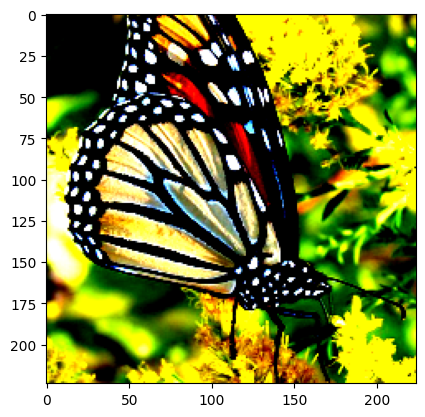

In [16]:
img_idx = 1

show_tensor_img(img[img_idx])

In [17]:
_ = proto_model(img)

In [18]:
proto_model.num_tokens

[184, 171, 158, 145, 132, 119, 106, 93, 80, 67, 54, 41]

In [19]:
def idx_mapping(selected_idx_list, num_tokens=196):
    """
    selected_idx_list: a list of tensors, tensor: [B, L]
    return: 
    A list of slected_idx mapping back to image idx
    """
    B, _ = selected_idx_list[0].shape
    idx = torch.arange(num_tokens).expand(B, -1)
    mapping_idx = []

    for selected_idx in selected_idx_list:
        idx = torch.gather(idx, dim=1, index=selected_idx)
        mapping_idx.append(idx)

    return mapping_idx

In [20]:
mapping_idx = idx_mapping(proto_model.idx_tracker)

In [21]:
mapping_idx[0].shape

torch.Size([2, 183])

In [22]:
first_idx = mapping_idx[0][img_idx]
first_idx

tensor([ 31,  46, 140,  85,  71,  99,  45, 133, 149,  58, 113,  20, 147,   3,
        134, 148,  21,  47,  17,  49,   6, 100,  74, 102,  35,  62, 135, 120,
         64, 116,  77,   0,   2, 184, 101, 131,  90,  98,  76, 115,  15,  29,
         55,  63,   1,  44,  88, 106,  61,  19,  50,  87,  18, 112,  72, 114,
        126, 119,  41,  32, 128,  57,  78,  16,  34,  28,  48,  73,  14,  30,
        146,  43,  75, 130,  91,  60, 154, 104,  84, 150, 139, 129, 103,  92,
         89, 105,  27, 118, 170,  59,  42,   5,  86, 132,   4, 117,  56,   7,
        127, 125,  36,  33, 109, 161,  13, 172, 145, 138, 171, 162,  70, 136,
        107, 110, 181,  82, 121,  95, 144, 143, 158, 163, 175,  69,  79, 152,
        173, 111, 164, 176,  12, 124,  26, 123,  93, 159,  54, 151, 153,  68,
        165,  65, 155,  37,  96, 192,  40,  80, 169, 177, 168, 185,  81, 178,
        141,  67, 137, 167,  66, 193, 166, 108, 122, 186,  94,  97, 183, 191,
        190, 157,  83, 174, 182, 189, 195, 142, 160, 180,  22,  

In [23]:
first_idx

tensor([ 31,  46, 140,  85,  71,  99,  45, 133, 149,  58, 113,  20, 147,   3,
        134, 148,  21,  47,  17,  49,   6, 100,  74, 102,  35,  62, 135, 120,
         64, 116,  77,   0,   2, 184, 101, 131,  90,  98,  76, 115,  15,  29,
         55,  63,   1,  44,  88, 106,  61,  19,  50,  87,  18, 112,  72, 114,
        126, 119,  41,  32, 128,  57,  78,  16,  34,  28,  48,  73,  14,  30,
        146,  43,  75, 130,  91,  60, 154, 104,  84, 150, 139, 129, 103,  92,
         89, 105,  27, 118, 170,  59,  42,   5,  86, 132,   4, 117,  56,   7,
        127, 125,  36,  33, 109, 161,  13, 172, 145, 138, 171, 162,  70, 136,
        107, 110, 181,  82, 121,  95, 144, 143, 158, 163, 175,  69,  79, 152,
        173, 111, 164, 176,  12, 124,  26, 123,  93, 159,  54, 151, 153,  68,
        165,  65, 155,  37,  96, 192,  40,  80, 169, 177, 168, 185,  81, 178,
        141,  67, 137, 167,  66, 193, 166, 108, 122, 186,  94,  97, 183, 191,
        190, 157,  83, 174, 182, 189, 195, 142, 160, 180,  22,  

In [24]:
vis_trfm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

vis_ds = SubImageNet(root, transform=vis_trfm)
vis_dl = DataLoader(vis_ds, batch_size=2, shuffle=False, num_workers=8)

img, _ = next(iter(vis_dl))

In [25]:
img = img[img_idx].detach().cpu().permute(1, 2, 0)

In [26]:
img.shape

torch.Size([224, 224, 3])

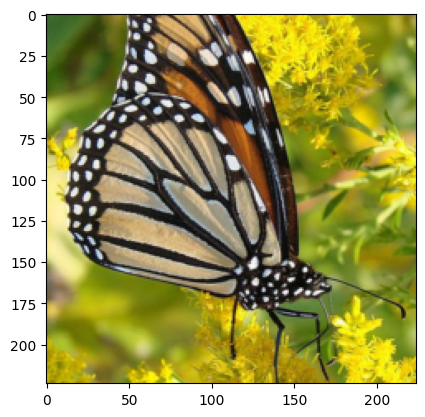

In [27]:
plt.imshow(img)

In [28]:
import cv2

In [29]:
def idx2xy(idx, num_patch=14):
    return idx // num_patch, idx % num_patch

In [30]:
idx2xy(115)

(8, 3)

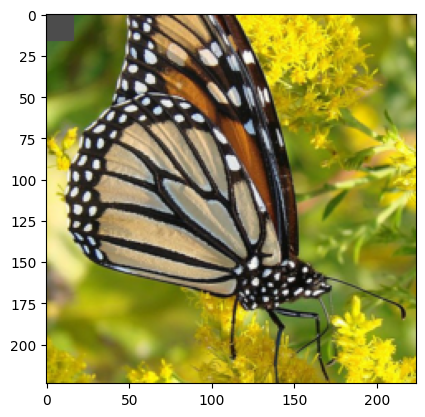

In [31]:
pw = ph = 224 // 14
x, y = idx2xy(0)
start = (pw * x, ph * y)
end = (pw * x + pw, ph * y + ph)
color = (0.3, 0.3, 0.3)
new_img = cv2.rectangle(cv2.cvtColor(img.numpy(), cv2.COLOR_RGB2BGR), start, end, color, -1)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

In [32]:
def make_a_patch(img, idx, img_size=224, num_patch=14, color=(0.3, 0.3, 0.3)):
    pw = ph = img_size // num_patch
    if isinstance(idx, torch.Tensor):
        idx = idx.item()
    x, y = idx2xy(idx)
    
    start = (pw * x, ph * y)
    end = (pw * x + pw, ph * y + ph)
    new_img = cv2.rectangle(img, start, end, color, -1)
    return new_img

In [33]:
def make_patches(img, idxes):
    res_img = img.numpy()
    res_img = cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR)

    for idx in idxes:
        res_img = make_a_patch(res_img, idx)
    
    return cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)

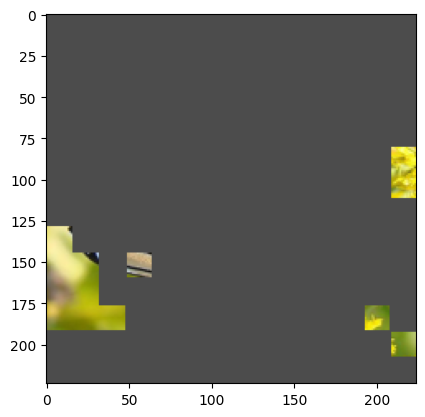

In [34]:
plt.imshow(make_patches(img, first_idx))

In [35]:
set(torch.arange(196).tolist()) - set(mapping_idx[0][0].tolist())

{26, 30, 94, 95, 96, 99, 108, 110, 114, 122, 124, 170, 175}

In [36]:
def get_inverse_idx(idx):
    return set(torch.arange(196).tolist()) - set(idx.tolist())

In [37]:
mapping_idx[0][img_idx]

tensor([ 31,  46, 140,  85,  71,  99,  45, 133, 149,  58, 113,  20, 147,   3,
        134, 148,  21,  47,  17,  49,   6, 100,  74, 102,  35,  62, 135, 120,
         64, 116,  77,   0,   2, 184, 101, 131,  90,  98,  76, 115,  15,  29,
         55,  63,   1,  44,  88, 106,  61,  19,  50,  87,  18, 112,  72, 114,
        126, 119,  41,  32, 128,  57,  78,  16,  34,  28,  48,  73,  14,  30,
        146,  43,  75, 130,  91,  60, 154, 104,  84, 150, 139, 129, 103,  92,
         89, 105,  27, 118, 170,  59,  42,   5,  86, 132,   4, 117,  56,   7,
        127, 125,  36,  33, 109, 161,  13, 172, 145, 138, 171, 162,  70, 136,
        107, 110, 181,  82, 121,  95, 144, 143, 158, 163, 175,  69,  79, 152,
        173, 111, 164, 176,  12, 124,  26, 123,  93, 159,  54, 151, 153,  68,
        165,  65, 155,  37,  96, 192,  40,  80, 169, 177, 168, 185,  81, 178,
        141,  67, 137, 167,  66, 193, 166, 108, 122, 186,  94,  97, 183, 191,
        190, 157,  83, 174, 182, 189, 195, 142, 160, 180,  22,  

In [38]:
all_reducted_idx = [get_inverse_idx(idx[img_idx]) for idx in mapping_idx]

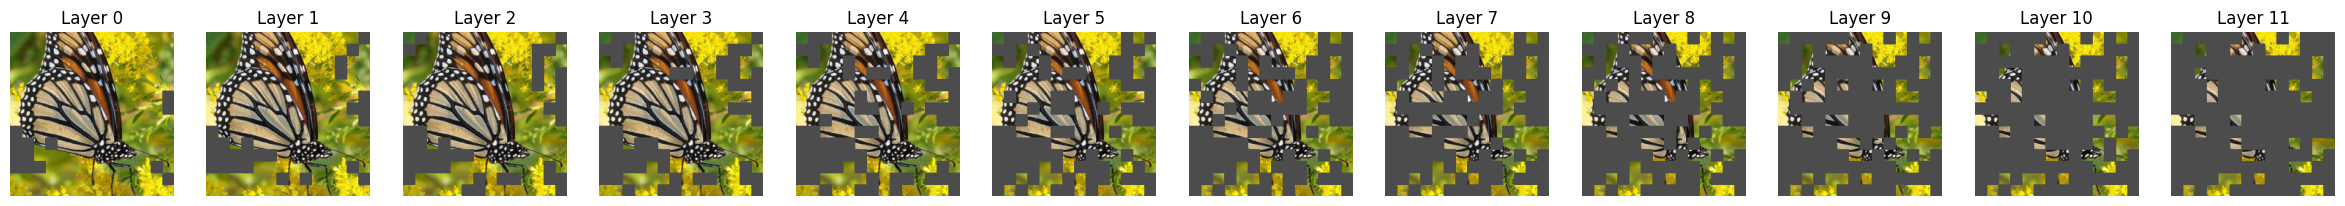

In [39]:
f, axes = plt.subplots(1, len(all_reducted_idx), figsize=(30, 10))

for layer_idx, (idxes, ax) in enumerate(zip(all_reducted_idx, axes.ravel())):
    ax.imshow(make_patches(img, idxes))
    ax.axis(False)
    ax.set_title(f"Layer {layer_idx}")    

In [44]:
test = torch.arange(196).reshape(14, 14)
test

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13],
        [ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27],
        [ 28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41],
        [ 42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55],
        [ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
        [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97],
        [ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
        [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153],
        [154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
        [168, 169, 170, 171, 172, 173, 1

In [43]:
get_inverse_idx(first_idx)

{8, 9, 10, 11, 23, 24, 25, 39, 51, 179, 187, 188, 194}